In [1]:
import pandas as pd
import numpy as np
import re
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import f1
from gensim.models import FastText
import ipdb
import spacy
import tqdm

In [2]:
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets['tone'] = 0

In [3]:
neg_tweets

,0,1,2,text,tone,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,0,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",0,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",0,0,0,0,35,17,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...
111918,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0
111919,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0
111920,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0
111921,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0


In [4]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
pos_tweets

,0,1,2,text,tone,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
114906,411368729235054592,1386912922,diminlisenok,"Спала в родительском доме, на своей кровати......",1,0,0,0,1497,56,34,2
114907,411368729424187392,1386912922,qilepocagotu,RT @jebesilofyt: Эх... Мы немного решили сокра...,1,0,1,0,692,225,210,0
114908,411368796537257984,1386912938,DennyChooo,"Что происходит со мной, когда в эфире #proacti...",1,0,0,0,4905,448,193,13
114909,411368797447417856,1386912938,bedowabymir,"""Любимая,я подарю тебе эту звезду..."" Имя како...",1,0,0,0,989,254,251,0


In [5]:
all_tweets_data = pos_tweets.append(neg_tweets)
print(len(all_tweets_data))

226834


In [6]:
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]
tweets_data

,text,tone
95072,"- Да не плачь, дурочка моя, я люблю тебя и не ...",1
91683,"Мне прям надо в ""Время Приключений"" сниматься,...",1
28833,Что может быть с компом если он после нажатия ...,0
20112,все так хорошо сейчас. ходить с Лерой к дедушк...,1
114293,@JudasDramaQueen цель - следствие.) можно пост...,1
...,...,...
55433,@_Ganju ты мамке надеюсь не обещал что закончи...,0
61608,@loye_you Это был последний день в первой четв...,1
83562,"Как бы я не любила играть на фортепиано,это вс...",1
103046,@fitzgerrald @timque Юличка! вы мне счет-факту...,0


In [7]:
# def preprocess(text):
#     tokens = text.lower().split()
#     tokens = [token.strip(punctuation) for token in tokens]
#     return tokens

In [118]:
from string import punctuation
punctuation += '...' + '—' + '…' + '«»'


def preprocess(text): 
#    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
#    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
#    text = re.sub(' +', ' ', text)
#    text = [token.strip() for token in text.split()]
    return text.split()

In [119]:
import re
tweets_data['preprocess'] = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))

In [120]:
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.2)

In [121]:
vocab = Counter()

for text in tweets_data['preprocess']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 244771


In [122]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 5 раз: 14982


In [123]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [124]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [125]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [126]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
        y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
        return padded_ids, y

In [127]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
batch = next(iter(train_iterator))

In [128]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)
test_batch = next(iter(val_iterator))

In [129]:
batch, y = next(iter(val_iterator))
print(batch, y)

tensor([[13862,  6345,  7522,  ...,     0,     0,     0],
        [12314, 11535,  7968,  ...,     0,     0,     0],
        [11261,  2049, 13862,  ...,     0,     0,     0],
        ...,
        [ 4557,  2370,  8856,  ...,     0,     0,     0],
        [    0,     0,     0,  ...,     0,     0,     0],
        [12898, 14558,  4970,  ...,     0,     0,     0]], device='cuda:0') tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]], device='cuda:0')


In [20]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=160, out_channels=40, kernel_size=3, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=40, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #print(feature_map_bigrams.shape)
        #print(feature_map_trigrams.shape)
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        third_conv = self.dropout(self.pooling(self.relu(self.sec_conv(concat))))
        pooling1 = third_conv.max(2)[0]

        logits = self.hidden(pooling1) 
        logits = self.out(self.dropout(logits))      
        return logits

# TRAIN

In [21]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [22]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [23]:
def learning(n_epochs, model, optimizer, criterion):
    for i in range(n_epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, train_iterator, criterion)
        f1s.append(f1_on_train.cpu())
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test.cpu())

In [24]:
%%capture

model = CNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(15, model, optimizer, criterion)

In [25]:
pass

# Оценка

In [26]:
from tqdm import tqdm


def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):
            preds = model(texts)  # делаем предсказания на тесте
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [27]:
import matplotlib.pyplot as plt
def printer_bce():
    plt.plot(losses)
    plt.plot(losses_eval)
    plt.title('BCE loss value')
    plt.ylabel('BCE loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [28]:
def printer_f1():
    plt.plot(f1s)
    plt.plot(f1s_eval)
    plt.title('f1 value')
    plt.ylabel('f1 value')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [29]:
def get_all(model, val_iterator):
    printer_bce()
    printer_f1()
    fp, fn, tp, tn = predict(model, val_iterator)
    recall = len(tp)/(len(tp) + len(fn))
    precision = len(tp)/(len(tp) + len(fp))
    f_score = 2 * precision * recall / (precision + recall)
    print(f_score)
    print('FN:', fn[:10])
    print('FP:', fp[:10])

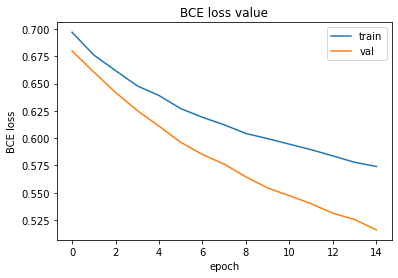

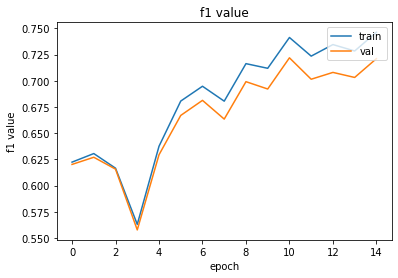

20it [00:30,  1.53s/it]

0.7215894039735099
FN: ['своё он хоть кому может отдать по', '#HappyBirthdayIanFromRussia Мне он никогда не Не понимаю, почему по нему все Но с днем', 'один в на той неделе а второй вчера в', 'завтра у отца др. я купил ибо забыл взять деньги вчера', 'Не могу выступать и петь на голодный и постоянно думаю о #еда', 'это', 'пишу программу по с музыкой с 4 час', 'Пока был в нормального интернета скачал Я такой До еще часа 1.5', 'под по как в последний', 'RT я сейчас буду -ну я не сказала бы что -ну']
FP: ['нет, на но сначала в проводить человека а это к пол 8 на', 'Папа посмотрел Нет бы сказать молодец троек меньше сто сказал он "все ты', 'твит Счастья вам, вы Люблю', 'дома так никто не не танцует до ужаса непривычно', 'RT птички ага, Настя на улице', 'ну просто ахуеть как смешно.', 'Как же я хочу обратно, дайте мне машину', 'везет, я уроки какую песню', 'а вы, блин, специально с', 'Спасибо за солнышко и У нас в окно лучше не смотреть(']


In [30]:
get_all(model, val_iterator)

Аналитика: <br>
* FN встречается слово "не", мб оно негативно окрашивает
* FP встречаются смайлики (скобочки), модель их не обрабатывает

Я хочу сначала попробовать разные параметры и выбрать лучшую модель. Каждый тест запускался дважды. По-хорошему надо сделать функцию гридсерча и запускть по 5 раз хотя бы, но нет таких возможностей для вычислений)
<br>

Скор, частслов, препроц, out1_kern, out2_kern, out3_kern, pool, lenemb<br>
__ Меняю длину эмб<br>
0.63, 2, прост, 100_2, 100_3, 100_3, 2-2, 10 <br>
0.60, 2, прост, 100_2, 100_3, 100_3, 2-2, 20 <br>
0.64, 2, прост, 100_2, 100_3, 100_3, 2-2, 5 ! <br>
0.64, 2, прост, 100_2, 100_3, 100_3, 2-2, 7 <br>

__ меняю препроц <br>
0.63, 5, прост, 100_2, 100_3, 100_3, 2-2, 5<br>
0.61, 5, хабр, 100_2, 100_3, 100_3, 2-2, 5<br>
0.74, 5, нет, 100_2, 100_3, 100_3, 2-2, 5 <br>
0.72, 5, только USER, 100_2, 100_3, 100_3, 2-2, 5<br>
0.75, 5, USER адреса, 100_2, 100_3, 100_3, 2-2, 5 !<br>
0.6, 5, USER адреса и стрип, 100_2, 100_3, 100_3, 2-2, 5<br>

__ меняю сетку
0.75, 5, USER адреса, 60_2, 100_3, 100_3, 2-2, 5<br>
0.73, 5, USER адреса, 60_2, 80_3, 100_3, 2-2, 5<br>
0.72, 5, USER адреса, 60_2, 120_3, 100_3, 2-2, 5<br>
0.75, 5, USER адреса, 60_2, 100_3, 80_3, 2-2, 5<br>!
0.74, 5, USER адреса, 60_2, 100_3, 80_2, 2-2, 5<br>
0.73, 5, USER адреса, 60_2, 100_3, 160_2, 2-2, 5<br>
0.73, 5, USER адреса, 60_2, 100_3, 160_3???, 2-2, 5<br>
0.74, 5, USER адреса, 60_2, 100_3, 40_2, 2-2, 5<br>
0.74, 5, USER адреса, 60_2, 100_3, 40_3, 2-2, 5<br>
<br>
0.755, 5, USER адреса, 60_2, 100_3, 80_3, 2-1, 5<br>
0.7, 5, USER адреса, 60_2, 100_3, 80_3, 2-3, 5<br>
0.72, 5, USER адреса, 60_2, 100_3, 80_3, 3-1, 5<br>
0.72, 5, USER адреса, 60_2, 100_3, 80_3, 2-1, 5<br>

0.765, 5, USER адреса, 60_2, 100_3, 40_3, 2-1, 5 !!!<br>
0.74, 5, USER адреса, 60_2, 100_3, 40_2, 2-1, 5<br>



# FASTTEXT Embeddings<br>
Подумал, что сохраню в дф препроцесенные значения, чтобы не делать много раз

In [31]:
from gensim.models import FastText

In [86]:
texts = tweets_data.preprocess.tolist()

In [87]:
texts

['- Да не плачь, дурочка моя, я люблю тебя и не брошу никогда! - Придурок, у меня ноготь сломался, а ты тут со своей любовью. :D',
 'Мне прям надо в "Время Приключений" сниматься, я прям как принцесса пупырка) URL',
 'Что может быть с компом если он после нажатия кнопки включения включается на секунду и тут-же выключается? ( мат-плата Zo',
 'все так хорошо сейчас. ходить с Лерой к дедушке зимой и пить чай уже традиция :D &lt;3',
 'USER цель - следствие.) можно постоянно желать чего-то не ставя цели этого добиться. Поэтому я выделила именно цели и мечты',
 'RT USER USER Огааа.. Я ещё в большей жопе жила)',
 'Как же мне плохо..светлый праздник пасхи перерос в темный понедельник.. :D',
 'История, я тебя ненавижу. Но я тебя все равно сдам, тварь ты такая!) Правда, будет хорошо, если я до этого момента не повешусь',
 'Короче это были его же дружки. Он их тоже потом попытался кинуть и они ему разбили ебло и машину) карма, мразь',
 'RT USER USER хорошо Спасиб))* Удачьки тебе в шк',
 'Я все вк

In [107]:
fasttext = FastText([text.split() for text in texts], vector_size=100, window=5, min_count=1)

In [108]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext.wv[word]    
    except KeyError:
        count += 1
        weights[i] = np.random.normal(0,0.1,100)

In [109]:
class CNN_fasttext(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=160, out_channels=40, kernel_size=3, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=40, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #print(feature_map_bigrams.shape)
        #print(feature_map_trigrams.shape)
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        third_conv = self.dropout(self.pooling(self.relu(self.sec_conv(concat))))
        pooling1 = third_conv.max(2)[0]

        logits = self.hidden(pooling1) 
        logits = self.out(self.dropout(logits))      
        return logits

In [114]:
fast_model = CNN_fasttext(len(word2id), 5)
fast_optimizer = optim.Adam(fast_model.parameters(), lr=0.001)
fast_criterion = nn.BCELoss()  
fast_model = fast_model.to(DEVICE)
fast_criterion = fast_criterion.to(DEVICE)

In [115]:
%%capture

losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(15, fast_model, fast_optimizer, fast_criterion)

Пробовал с теми же параметрами, пользы нет. Попробую поменять параметры фасттекста.


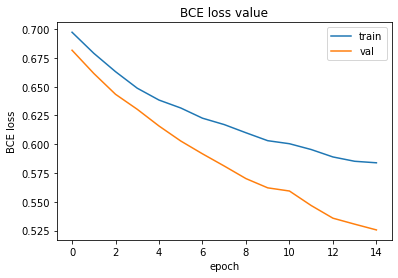

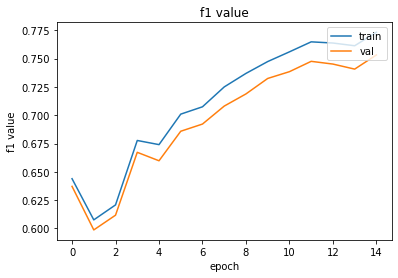

20it [00:29,  1.48s/it]

0.7538461538461539
FN: ['У меня Но мне кажется я Что делаешь?', 'Расскажи что-нибудь чего я не', 'скажите, пожалуйста , как к вам попасть на ??? Спасибо', 'не 3 с лишним недели, настало время)', 'не, я спать не могу, потому что у меня завал в одна с бутылкой и а ты?', 'Много всё удастся очень рада !)', 'Сегодня я устроила у себя дома уроки', 'RT 10 новогодних блюд, которые изменят вашу жизнь: 1)', 'так после нг и лучше даже. Сейчас и так денег надо)', 'RT @navalny своей первой радуешься как так тока когда вторую']
FP: ['#RT — бесплатно на 2014 год via', 'не знаю как(', 'хочется но я не что скоро Новый', 'да блин, сидит в в наушниках, сам себя не и такой невозможно', 'ещё же сочинение писать. если бы не увидела у тебя , то вообще забыла бы', 'последние 2 дня и мы будем редко', 'почему он так с нами', 'У меня сейчас такое ужасное Все плохо...', 'месяц проебал больше', 'Как мне хочется уснуть и забыть о']


In [116]:
get_all(fast_model, val_iterator)

Аналитика: <br>
* FN опять встречается слово "не"
* FP опять скобочки

### Попробую без обработки (пользы нет)

In [83]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}
    
MAX_LEN = 0

for text in tweets_data.text:
    tokens = text
    MAX_LEN = max(len(tokens), MAX_LEN)
print(MAX_LEN)
    
    
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

всего уникальных токенов: 305733
уникальных токенов, втретившихся больше 5 раз: 15662
189


In [84]:
texts = tweets_data.text.tolist()
texts

['- Да не плачь, дурочка моя, я люблю тебя и не брошу никогда! - Придурок, у меня ноготь сломался, а ты тут со своей любовью. :D',
 'Мне прям надо в "Время Приключений" сниматься, я прям как принцесса пупырка) http://t.co/t3i7Hoso1B',
 'Что может быть с компом если он после нажатия кнопки включения включается на секунду и тут-же выключается? ( мат-плата Zo',
 'все так хорошо сейчас. ходить с Лерой к дедушке зимой и пить чай уже традиция :D &lt;3',
 '@JudasDramaQueen цель - следствие.) можно постоянно желать чего-то не ставя цели этого добиться. Поэтому я выделила именно цели и мечты',
 'RT @Nanananabooms: @My_Life_Rock_ Огааа.. Я ещё в большей жопе жила)',
 'Как же мне плохо..светлый праздник пасхи перерос в темный понедельник.. :D',
 'История, я тебя ненавижу.\nНо я тебя все равно сдам, тварь ты такая!)\nПравда, будет хорошо, если я до этого момента не повешусь',
 'Короче это были его же дружки. Он их тоже потом попытался кинуть и они ему разбили ебло и машину) карма, мразь',
 'RT @ad

In [73]:
fasttext = FastText([text.split() for text in texts], vector_size=100, window=5, min_count=1)

In [74]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext.wv[word]    
    except KeyError:
        count += 1
      # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

In [75]:
fast_model = CNN_fasttext(len(word2id), 5)
fast_optimizer = optim.Adam(fast_model.parameters(), lr=0.001)
fast_criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
fast_model = fast_model.to(DEVICE)
fast_criterion = fast_criterion.to(DEVICE)

In [76]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(15, fast_model, fast_optimizer, fast_criterion)


starting Epoch 0
Training...
Train loss: 0.7669102038655963
Train loss: 0.7319365780929039
Train loss: 0.7197456793351606
Train loss: 0.7128957065485292
Train loss: 0.7086202453922581

Evaluating on train...
Val loss: 0.7317360128675189, Val f1: 0.6941352486610413
Val loss: 0.7058678433812898, Val f1: 0.6719212532043457
Val loss: 0.6976657482710752, Val f1: 0.6659330129623413
Val loss: 0.6935375060065317, Val f1: 0.6627911925315857
Val loss: 0.6910641233663302, Val f1: 0.6616637110710144

Evaluating on test...
Val loss: 0.9091637333234152, Val f1: 0.8791588544845581
Val loss: 0.7803640025002616, Val f1: 0.7465465068817139
Val loss: 0.7451707774942572, Val f1: 0.70936119556427
Val loss: 0.7289202690124512, Val f1: 0.6890127658843994
Val loss: 0.7191018870002345, Val f1: 0.6810286641120911

starting Epoch 1
Training...
Train loss: 0.7383485010692051
Train loss: 0.7125403737199718
Train loss: 0.7024101736870679
Train loss: 0.6973302758346169
Train loss: 0.6937039438131694

Evaluating on 

Val loss: 0.590521799666541, Val f1: 0.7731101512908936
Val loss: 0.5704253007625711, Val f1: 0.7418587803840637
Val loss: 0.5640128729018298, Val f1: 0.7336656451225281
Val loss: 0.5610480146893, Val f1: 0.7285832762718201
Val loss: 0.5579166049892837, Val f1: 0.7283297777175903

Evaluating on test...
Val loss: 0.7405291597048441, Val f1: 0.9516289234161377
Val loss: 0.6387028438704354, Val f1: 0.798968493938446
Val loss: 0.60854172706604, Val f1: 0.7639665603637695
Val loss: 0.5947621822357178, Val f1: 0.7434968948364258
Val loss: 0.5859785362293846, Val f1: 0.7353225350379944

starting Epoch 11
Training...
Train loss: 0.6387516983917781
Train loss: 0.6169159165744124
Train loss: 0.6096134768290953
Train loss: 0.6047279996387029
Train loss: 0.6014897549474562

Evaluating on train...
Val loss: 0.5789189083235604, Val f1: 0.8041298985481262
Val loss: 0.5600313338740118, Val f1: 0.775179386138916
Val loss: 0.5532846599817276, Val f1: 0.7675744295120239
Val loss: 0.5510265584719383, Val 

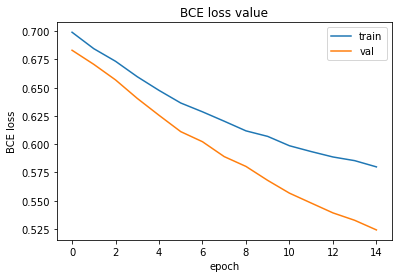

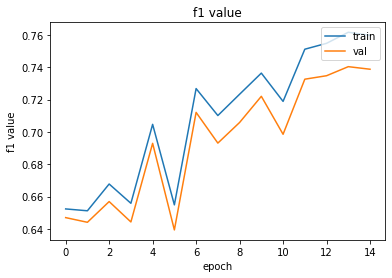

20it [00:31,  1.56s/it]

0.739577099541193
FN: ['Мое лицо когда увидела новую', 'Теперь в классе меня все называют', 'Расскажи что-нибудь чего я не', 'кто', 'свою вчерашнюю и не только вчерашнюю', 'RT песни, которые Вика сама, нереально поднимают настроение)', 'не 3 с лишним недели, настало время)', ',так надо', 'Сегодня я устроила у себя дома уроки', 'С 14 числа начинаю начнём мы с делать всё']
FP: ['ну у меня так каждый день. Уже', '#RT — бесплатно на 2014 год via', 'не знаю как(', 'хотела у тебя есть( ахах', 'да блин, сидит в в наушниках, сам себя не и такой невозможно', 'почему он так с нами', 'У меня сейчас такое ужасное Все плохо...', 'Как мне хочется уснуть и забыть о', 'в том, что сам он никогда не ! А его - это РФ будет голосовать за до', 'Меня хотят дома оставить типа др дома отмечать с Москве это не и']


In [85]:
get_all(fast_model, val_iterator)

### Лучше не стало. Перехожу к двум входам <br>
Начну с простым препроцом

In [314]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [316]:
tweets_data['s_preprocess'] = tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.2)

In [320]:
vocab_sym = Counter()
for symbol in tweets_data['s_preprocess']:
    vocab_sym.update(list(symbol))
print('всего уникальных символов:', len(vocab_sym))

filtered_vocab_sym = set()

for symb in vocab_sym:
    if vocab_sym[symb] > 5:
        filtered_vocab_sym.add(symb)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab_sym))

symb2id = {'PAD':0}

for symb in filtered_vocab_sym:
    symb2id[symb] = len(symb2id)
    
id2symbol = {i:symb for symb, i in symb2id.items()}

всего уникальных символов: 276
уникальных токенов, втретившихся больше 5 раз: 143


In [321]:
texts = tweets_data['s_preprocess'].tolist()

In [322]:
fasttext = FastText([text.split() for text in texts], vector_size=100, window=5, min_count=1)

In [323]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = fasttext.wv[word]    
    except KeyError:
        count += 1
      # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,100)

In [328]:
class S_W_TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['s_preprocess'].values
        self.word2id = word2id
        self.symb2id = symb2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # пробелы тоже учитываются
        symbols = list(self.dataset[index])
        symbols_ids = torch.LongTensor([self.symb2id[symb] for symb in symbols if symb in self.symb2id])
        
        tokens = self.dataset[index].split()
        words_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        
        return words_ids, symbols_ids, y

    def collate_fn(self, batch):
        words_ids, symbols_ids, y = list(zip(*batch))
        padded_sym_ids = pad_sequence(symbols_ids, batch_first=True).to(self.device)
        padded_words_ids = pad_sequence(words_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_words_ids, padded_sym_ids, y

In [341]:
train_dataset = S_W_TweetsDataset(train_sentences, word2id, symb2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = S_W_TweetsDataset(val_sentences, word2id, symb2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [347]:
class W_S_CNN(nn.Module):
    
    def __init__(self, words_vocab_size, symbols_vocab_size, symbols_embedding_dim):
        super().__init__()
        self.words_embedding = nn.Embedding(words_vocab_size, 5)
        self.words_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.words_hidden = nn.Linear(in_features=5, out_features=100)

        self.sym_embedding = nn.Embedding(symbols_vocab_size, symbols_embedding_dim)        
        self.sym_bigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=60, kernel_size=2, padding='same')
        self.sym_trigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=100, kernel_size=3, padding='same')        
        self.symbols_hidden = nn.Linear(in_features=160, out_features=100)
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        embedded_symb = self.sym_embedding(symb_seq)
        embedded_symb = embedded_symb.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.sym_bigrams(embedded_symb))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.sym_trigrams(embedded_symb))))
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        symbols_concat = torch.cat((pooling1, pooling2), 1)
        symb_vec = self.symbols_hidden(symbols_concat)
        
        embedded_words = self.words_embedding(words_seq) 
        m_embedded_words = torch.mean(embedded_words, dim=1)
        #print(m_embedded_words.shape)
        sent_vec = self.relu(self.dropout(self.words_hidden(m_embedded_words)))
        #print(sent_vec.shape)
        concat = torch.cat((symb_vec, sent_vec), 1)
        #print(concat.shape)
        
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [343]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (words_seq, symbols_seq, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(words_seq, symbols_seq)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [344]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words_seq, symbols_seq, ys) in enumerate(iterator):   
            preds = model(words_seq, symbols_seq)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [345]:
def learning(n_epochs, model, optimizer, criterion):
    for i in range(n_epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, train_iterator, criterion)
        f1s.append(f1_on_train.cpu())
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test.cpu())

In [350]:
%%capture

model = W_S_CNN(len(word2id), len(symb2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(15, model, optimizer, criterion)

In [351]:
from tqdm import tqdm


def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in tqdm(enumerate(iterator)):
            preds = model(word_seq, symb_seq)  # делаем предсказания на тесте
            for pred, gold, text in zip(preds, ys, word_seq):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

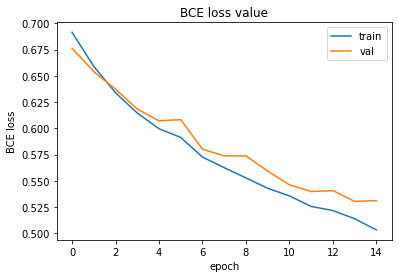

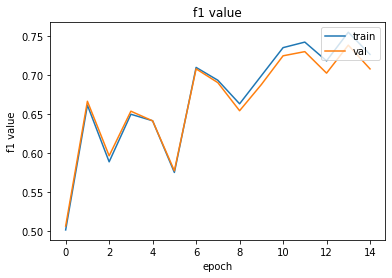

20it [00:29,  1.46s/it]

0.7071136549468521
FN: ['а не не кидаю ваше фото мне нечего сказать', 'вот и молодец а ваши парни школу от снега', 'да наша утром не хер найдешь новий', 'rt кто не лег вовремя спать тот будет своими мыслями', 'согласна', 'еще 19 дней и надо', 'порой чувство что я не найду вторую ибо мужчины младше 30 вообще по', 'rt ну вот спел этот от россии прикольно должен победить', 'а я с', 'что бы это ни было но оно там несколько дней']
FP: ['rt нет ли у кого-нибудь такого мой сдох ретвит', 'ты ко мне постоянно спиной стояла', 'я тоже и пойду', 'по реклама мы за мир за без я тоже но реклама так часто что похоже на заказ пр хотя майдан', 'хочу стипендия скоро ты уже а', 'ага до 5 скажи ей пусть', 'это нереально есть такие люди я очень вас люблю но мне очень не хватает семьи и', 'сам читай книги давай мне уже пришлось в твите', 'по физике кр была 4 задания из 5 сделала 3 получу походу', 'часто ли ты в людях да очень']


In [352]:
get_all(model, val_iterator)

Аналитика: <br>
Тут ниче не понятно

Уберу препроц почти совсем

In [354]:
vocab_sym = Counter()
for symbol in tweets_data['preprocess']:
    vocab_sym.update(list(symbol))
print('всего уникальных символов:', len(vocab_sym))

filtered_vocab_sym = set()

for symb in vocab_sym:
    if vocab_sym[symb] > 1:
        filtered_vocab_sym.add(symb)
print('уникальных токенов, втретившихся больше 1 раза:', len(filtered_vocab_sym))

symb2id = {'PAD':0}

for symb in filtered_vocab_sym:
    symb2id[symb] = len(symb2id)
    
id2symbol = {i:symb for symb, i in symb2id.items()}

всего уникальных символов: 349
уникальных токенов, втретившихся больше 1 раза: 281


In [355]:
class S_W_TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['preprocess'].values
        self.word2id = word2id
        self.symb2id = symb2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # пробелы тоже учитываются
        symbols = list(self.dataset[index])
        symbols_ids = torch.LongTensor([self.symb2id[symb] for symb in symbols if symb in self.symb2id])
        
        tokens = self.dataset[index].split()
        words_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        
        return words_ids, symbols_ids, y

    def collate_fn(self, batch):
        words_ids, symbols_ids, y = list(zip(*batch))
        padded_sym_ids = pad_sequence(symbols_ids, batch_first=True).to(self.device)
        padded_words_ids = pad_sequence(words_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_words_ids, padded_sym_ids, y

In [356]:
train_dataset = S_W_TweetsDataset(train_sentences, word2id, symb2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = S_W_TweetsDataset(val_sentences, word2id, symb2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [357]:
%%capture

model = W_S_CNN(len(word2id), len(symb2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

learning(15, model, optimizer, criterion)

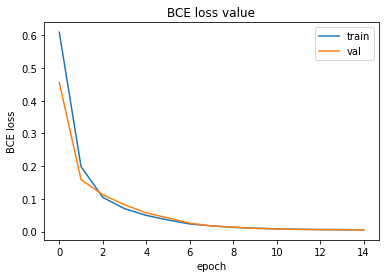

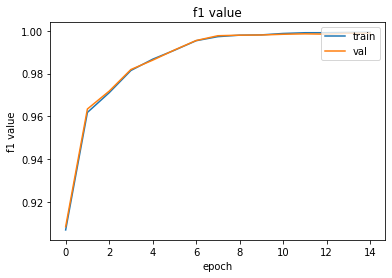

20it [00:33,  1.67s/it]

0.9988595229830911
FN: ['МОИ :** Я ВАС о/', 'научился', 'работы с кем-то в другом городе - я уже пошла на обед, а человек как раз пришёл на гораздо хуже когда', 'для нового USER самого', '"USER Я ТОЖЕ ВАС URL', 'RT USER "USER Че за фигня творится с мамы дяди URL', 'театр Ла год URL после надо теперь сюда, да USER', 'Почему в России так не любят Ведь у нас в стране все делается через', 'URL с помощью USER', 'RT USER Сегодня с дали характер твитов людей из нашей школы. USER']
FP: ['RT USER USER в новый год для ^-^', 'RT USER Люблю этот фильм *о* URL', 'Увидела у одного парня почти 150 тыщ Какой кошмар, это как надо писать, :-/ Я себя за свои 18 тыщ :-D', 'Как URL', 'С твиттерский USER Хороших друзей и приятных моментов', 'USER не, просто я выиграл две олимпиады сразу, вот мне и', 'Даже не знаю, доделать машину или купить o_O', 'USER я не и Поэтому гоу хD', 'RT USER USER МОЯ ЛЮБИМАЯ **', 'RT USER за окном светит или какой то с #SLEDUI']


In [358]:
get_all(model, val_iterator)

Другое дело. В FP встречаются большие цифры, про FN непонятно. Но резы шикарные, выяснили, что дело в пунктуации - смайликах, скобочках (что раньше вылезало в негативы) и прочем.